Load Julia packages (libraries) needed

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain
gr(size=(500,500));

┌ Warning: Package Turing does not have CmdStan in its dependencies:
│ - If you have Turing checked out for development and have
│   added CmdStan as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Turing
│ Loading CmdStan into Turing from project dependency, future warnings for Turing are suppressed.
└ @ nothing nothing:840


CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "02")
cd(ProjDir)

Define the Stan language model

In [3]:
binomialstanmodel = "
// Inferring a Rate
data {
  int N;
  int<lower=0> k[N];
  int<lower=1> n[N];
}
parameters {
  real<lower=0,upper=1> theta;
  real<lower=0,upper=1> thetaprior;
}
model {
  // Prior Distribution for Rate Theta
  theta ~ beta(1, 1);
  thetaprior ~ beta(1, 1);

  // Observed Counts
  k ~ binomial(n, theta);
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [4]:
stanmodel = Stanmodel(name="binomial", monitors = ["theta"], model=binomialstanmodel,
  output_format=:mcmcchain);
# Use 16 observations
N2 = 15
d = Binomial(9, 0.66)
n2 = Int.(9 * ones(Int, N2));

Show first 5 (generated) observations

In [5]:
k2 = rand(d, N2);
k2[1:min(5, N2)]

5-element Array{Int64,1}:
 5
 6
 5
 5
 5

Input data for cmdstan

In [6]:
binomialdata = Dict("N" => length(n2), "n" => n2, "k" => k2);

Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, binomialdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)


Inference for Stan model: binomial_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.028, 0.028, 0.028, 0.030) seconds, 0.11 seconds total
Sampling took (0.041, 0.041, 0.045, 0.040) seconds, 0.17 seconds total

                Mean     MCSE  StdDev     5%   50%   95%    N_Eff  N_Eff/s    R_hat
lp__             -90  2.5e-02     1.0    -92   -90   -89  1.7e+03  1.0e+04  1.0e+00
accept_stat__   0.90  2.0e-03    0.13   0.61  0.95   1.0  4.6e+03  2.7e+04  1.0e+00
stepsize__      0.86  4.4e-02   0.062   0.76  0.90  0.92  2.0e+00  1.2e+01  7.9e+13
treedepth__      1.9  6.7e-02    0.55    1.0   2.0   3.0  6.7e+01  4.0e+02  1.0e+00
n_leapfrog__     3.8  4.3e-01     2.7    1.0   3.0   7.0  3.9e+01  2.3e+02  1.0e+00
divergent__     0.00      nan    0.00   0.00  0.00  0.00      nan      nan      nan
energy__          91  3.7e-02     1.4     89    90    94  1.5e+03  9.0e+03  1.0e+00
theta           0.66  6.6e-04   0.039  

Allocate array of Normal fits

In [8]:
fits = Vector{Normal{Float64}}(undef, 4)
for i in 1:4
  fits[i] = fit_mle(Normal, convert.(Float64, chn.value[:, 1, i]))
  println(fits[i])
end

Normal{Float64}(μ=0.6639925809999992, σ=0.04133033478484585)
Normal{Float64}(μ=0.6663111840000002, σ=0.03732474468097732)
Normal{Float64}(μ=0.6634157099999998, σ=0.03862422965774076)
Normal{Float64}(μ=0.6641147359999993, σ=0.03812603301360245)


Plot the 4 chains

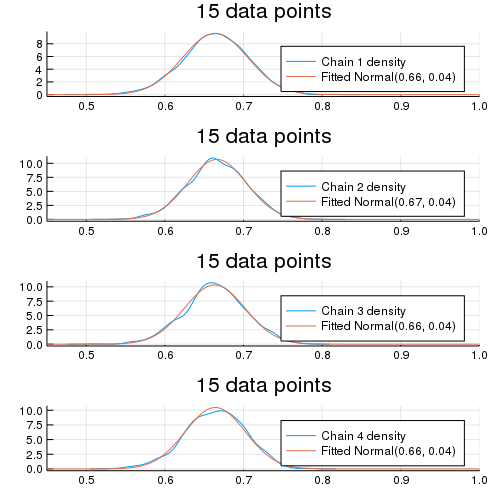

In [9]:
mu_avg = sum([fits[i].μ for i in 1:4]) / 4.0;
sigma_avg = sum([fits[i].σ for i in 1:4]) / 4.0;

if rc == 0
  p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
  x = 0:0.001:1
  for i in 1:4
    vals = convert.(Float64, chn.value[:, 1, i])
    μ = round(fits[i].μ, digits=2)
    σ = round(fits[i].σ, digits=2)
    p[i] = density(vals, lab="Chain $i density",
       xlim=(0.45, 1.0), title="$(N2) data points")
    plot!(p[i], x, pdf.(Normal(fits[i].μ, fits[i].σ), x), lab="Fitted Normal($μ, $σ)")
  end
  plot(p..., layout=(4, 1))
end

Compute at hpd region

In [10]:
bnds = MCMCChain.hpd(chn[:, 1, :], alpha=0.06);

Show hpd region

In [11]:
println("hpd bounds = $bnds\n")

hpd bounds =       94% Lower 94% Upper
theta  0.591479  0.736451





quadratic approximation

Compute MAP, compare with CmndStan & MLE



CmdStan: 0.6644585527499997)
MAP: [0.666667]
MLE: 0.6644585527499997

CmdStan sd: 0.038900922334416894
MAP sd: 0.038900922334416894
MLE sd: 0.0388513355342916



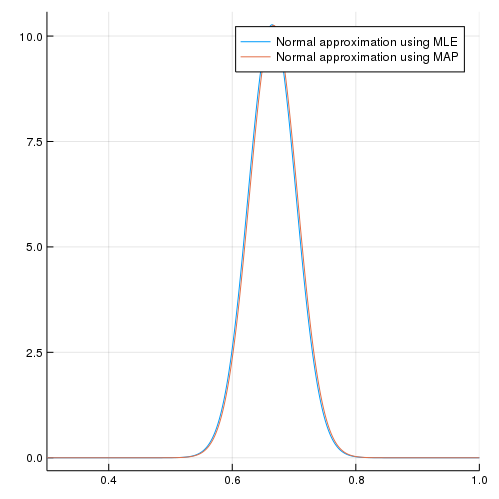

In [12]:
tmp = convert(Array{Float64,3}, chn.value)
draws = reshape(tmp, (size(tmp, 1)*size(tmp, 3)),)

using Optim

x0 = [0.5]
lower = [0.2]
upper = [1.0]

inner_optimizer = GradientDescent()

function loglik(x)
  ll = 0.0
  ll += log.(pdf.(Beta(1, 1), x[1]))
  ll += sum(log.(pdf.(Binomial(9, x[1]), k2)))
  -ll
end

println()
res2 = optimize(loglik, lower, upper, x0, Fminbox(inner_optimizer))
res2 |> display

println("\nCmdStan: $(mean(chn.value)))")
println("MAP: $(Optim.minimizer(res2))")
println("MLE: $(mu_avg)\n")

println("CmdStan sd: $(std(chn.value))")
println("MAP sd: $(std(draws, mean=mean(chn.value)))")
println("MLE sd: $(sigma_avg)\n")

plot( x, pdf.(Normal( mu_avg , sigma_avg  ) , x ),
xlim=(0.3, 1.0), lab="Normal approximation using MLE")
plot!( x, pdf.(Normal( Optim.minimizer(res2)[1] , std(draws, mean=mean(chn.value))) , x),
lab="Normal approximation using MAP")

Turing Chain &  89%hpd region boundaries

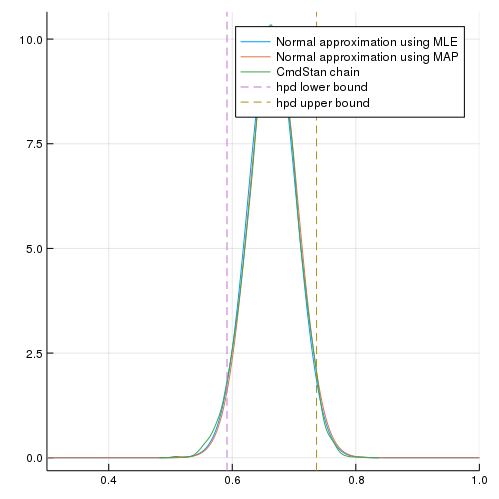

In [13]:
density!(draws, lab="CmdStan chain")
vline!([bnds.value[1]], line=:dash, lab="hpd lower bound")
vline!([bnds.value[2]], line=:dash, lab="hpd upper bound")

End of `clip_08s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*